In [1]:
!which python

/Users/liamkirwin/.local/share/virtualenvs/cicada-PMgweW5G/bin/python


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from cicada.utils import data
from cicada.utils import models
from cicada.utils import visualisation as viz
from cicada import training
from cicada import agent

In [4]:
from kaggle_environments.envs.football.helpers import human_readable_agent
from kaggle_environments import make

In [5]:
import numpy as np
import pandas as pd
from ipywidgets import interact
from copy import deepcopy
from tqdm.notebook import tqdm
import seaborn as sns
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV, RidgeClassifierCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
import joblib

In [7]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Single game with diagnostics

In [8]:
# agent = SimpleAgent()
agent.plans.models.reload_lgb_models_if_needed()
agent_obj = agent.Agent(noise_sd=0)

# Set up the Environment.
env = make("football", configuration={
    "save_video": True, 
    "scenario_name": "11_vs_11_kaggle",
#     "scenario_name": "academy_counterattack_hard",
#     "scenario_name": "academy_run_to_score_with_keeper", 
    "running_in_notebook": True,
    "episodeSteps": 1000,
})

trainer = env.train([None, "submission2.py"])
obs = trainer.reset()
while not env.done:
#     import pdb; pdb.set_trace()
    action = agent_obj.action_wrapper(obs)
    obs, reward, done, info = trainer.step(action)

env.render(mode="human", width=800, height=600)

Received video link.


In [9]:
fig = viz.make_figure_widget(30)

In [10]:
@interact(view_step=(0, len(env.steps) - 2))
def interactive_display(view_step=0):
    step = deepcopy(env.steps[view_step])
    log_step = agent_obj.state.log[view_step]
    state = data.State(data.step_to_obs(step))
    fig.update(data=viz.get_traces(state, log_step))
    viz.print_diagnostics(state, log_step)
fig

interactive(children=(IntSlider(value=0, description='view_step', max=998), Output()), _dom_classes=('widget-i…

FigureWidget({
    'data': [{'fillcolor': 'rgba(0,0,0,0)',
              'hoverinfo': 'text',
              'm…

In [11]:
stop

NameError: name 'stop' is not defined

In [ ]:
data.filter_log(agent_obj.state.log, type=("SHORT_PASS_ATTEMPT", "LONG_PASS_ATTEMPT", "NEW_POSSESSION"))

In [ ]:
tmp = data.filter_log(
    log=agent_obj.state.log,
    type=("SHORT_PASS_ATTEMPT", "NEW_POSSESSION"),
)
tmp = data.parse_log_to_df(tmp)
tmp

In [ ]:
data.filter_log(agent_obj.state.log, type=("MOVE_WITH_BALL_ATTEMPT", "LOST_POSSESSION"))

In [ ]:
viz.filter_log(agent_obj.state.log, type=("ACTIVE_POS_SCORE"))

# Many games

- 2020-11-03: trial for lgbm vs. linear for move/pass models, 100 games each, started at 4110
    - lgbm was better
- 2020-11-04: trial for breakaway vs. no breakaway, 100 games each, started at 5510
    - breakaway was better
- 2020-11-04: trial for ridge vs. lgbm for move/pass, 100 games each, started at 5710
    - lgbm very slightly
- 2020-11-04: trial for risk aversion 1.0 vs 1.5, 100 games each, started at 5810
    - 1.5 was much worse

In [12]:
scores = data.get_score_file_as_df()
scores["loss"] = 1 - scores.win - scores.tie
scores.shape

(1307, 5)

In [13]:
# scores.iloc[7676:7711]

In [14]:
scores.describe()

left_score  right_score          win          tie         loss
count  1307.000000  1307.000000  1307.000000  1307.000000  1307.000000
mean      1.809487     0.958684     0.589901     0.212701     0.197399
std       1.285317     0.987583     0.492040     0.409374     0.398188
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       1.000000     0.000000     0.000000     0.000000     0.000000
50%       2.000000     1.000000     1.000000     0.000000     0.000000
75%       3.000000     2.000000     1.000000     0.000000     0.000000
max       6.000000     6.000000     1.000000     1.000000     1.000000

<AxesSubplot:title={'center':'right_score'}>

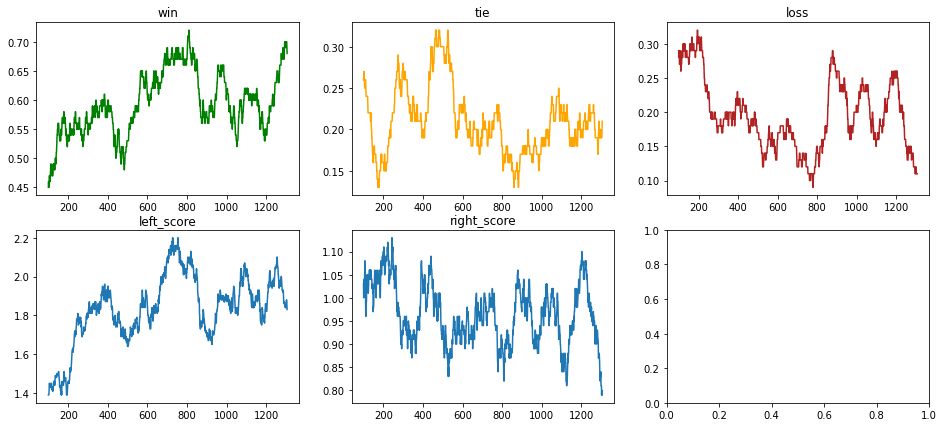

In [23]:
n_start = 0
grp_size = 100

su = scores.iloc[n_start:].rolling(grp_size).mean()
# su = scores.iloc[n_start:].groupby(scores.iloc[n_start:].index // grp_size).mean()

f, axes = plt.subplots(2, 3, figsize=(16, 7))
su.win.plot(ax=axes[0][0], title="win", color="green")
su.tie.plot(ax=axes[0][1], title="tie", color="orange")
su.loss.plot(ax=axes[0][2], title="loss", color="firebrick")
su.left_score.plot(ax=axes[1][0], title="left_score")
su.right_score.plot(ax=axes[1][1], title="right_score")

## Shot data

In [ ]:
shots = sim.make_shot_dataset()
shots.shape

In [ ]:
shots.head()

In [ ]:
shots.describe()

In [ ]:
shots.groupby(shots["eval_data.dist_to_goalie"].notna()).success.mean()

In [ ]:
shots.success.value_counts()

In [ ]:
shots.groupby("game_id").size().plot()

In [ ]:
for col in [
    "eval_data.view_of_net",
    "eval_data.distance_to_net",
    "eval_data.dist_to_goalie",
#     "eval_data.step",
]:
    f, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.kdeplot(x=shots[col][shots.success == 1], label="1", ax=axes[0])
    sns.kdeplot(x=shots[col][shots.success == 0], label="0", color="red", ax=axes[0])
    sns.regplot(x=shots[col], y=shots.success, x_bins=20, ax=axes[1])
    axes[0].legend()
    plt.show()

In [ ]:
sns.regplot(x=shots["eval_data.dist_to_goalie"].clip(lower=0.22), y=shots.success, x_bins=20)

## Short pass data

In [ ]:
short = models.make_short_pass_dataset()
short.shape

In [ ]:
short.groupby("game_id").size().plot()

In [ ]:
(short.step - short.queued_at).value_counts().sort_index().plot.bar()

In [ ]:
short["eval_data.timestep"].value_counts().plot.bar()

In [ ]:
short.head()

In [ ]:
short.describe()

In [ ]:
# short["pos_score_data.view.val"] = short["pos_score_data.view"].clip(upper=1)

In [ ]:
# short["eval_data.small_cone_angle"] = short["eval_data.small_cone_angle"].clip(upper=40)

In [ ]:
short_pass_cols = [
     "step",
     "eval_data.pass_error",
     "eval_data.pass_error_diff",
     "pos_score_data.posx",
     "pos_score_data.dnet",
     "pos_score_data.view",
     "pos_score_data.dopp",
     "eval_data.small_cone_angle",
     "eval_data.pass_distance",
     "eval_data.opp_dist_to_line",
     "eval_data.opp_dist_to_active",
     "eval_data.prb_success",
]

In [ ]:
tmp = short.sample(30_000)
for col in short_pass_cols:
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.kdeplot(x=tmp[col][tmp.target == 1], label="1", ax=axes[0])
    sns.kdeplot(x=tmp[col][tmp.target == 0], label="0", color="red", ax=axes[0])
    sns.regplot(x=tmp[col], y=tmp.target, x_bins=20, ax=axes[1])
    axes[0].legend()
    plt.show()

In [ ]:
sm.OLS(short.success, sm.add_constant(short[short_pass_cols])).fit().summary()

In [ ]:
short_pass_cols = [
#      "step",
#      "eval_data.pass_error",
     "eval_data.pass_error_diff",
     "pos_score_data.posx",
     "pos_score_data.dnet",
     "pos_score_data.view",
     "pos_score_data.dopp",
     "eval_data.small_cone_angle",
     "eval_data.pass_distance",
     "eval_data.opp_dist_to_line",
     "eval_data.opp_dist_to_active",
#      "eval_data.prb_success",
]

In [ ]:
sm.OLS(short.success, sm.add_constant(short[short_pass_cols])).fit().summary()

In [ ]:
model = LGBMClassifier()
grid = {
    "n_estimators": list(range(10, 201, 20)),
    "num_leaves": [10, 30],
}
# neg_log_loss, neg_brier_score, roc_auc, f1
grid_search = GridSearchCV(model, grid, scoring="neg_log_loss", verbose=1, n_jobs=5)
grid_search.fit(short[short_pass_cols], short.success)

In [ ]:
grid_search.best_params_

In [ ]:
sns.displot(grid_search.predict_proba(short[short_pass_cols])[:, 1])

In [ ]:
# pd.DataFrame(grid_search.cv_results_).sort_values("mean_test_score", ascending=False)

In [ ]:
grid_search.best_estimator_.booster_.save_model("short_pass_model.txt")

In [ ]:
short_pipe = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RobustScaler(quantile_range=(0.05, 0.95)),
    RidgeClassifierCV(alphas=(0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0), cv=10)
)

In [ ]:
short_pipe.fit(short[short_pass_cols], short.success)

In [ ]:
short_pipe.named_steps.ridgeclassifiercv.alpha_

In [ ]:
joblib.dump(short_pipe, "short_pass_model.pkl")

## Long pass data

In [ ]:
long = models.make_long_pass_dataset()
long.shape

In [ ]:
long.groupby("game_id").size().plot()

In [ ]:
(long.step - long.queued_at).value_counts().sort_index().plot.bar()

In [ ]:
long.head()

In [ ]:
long.describe()

In [ ]:
long["pos_score_data.view.val"] = long["pos_score_data.view.val"].clip(upper=1)

In [ ]:
long_pass_cols = [
     "step",
     "pass_error",
     "pass_error_diff",
     "pos_score_data.posx.val",
     "pos_score_data.dnet.val",
     "pos_score_data.view.val",
     "pos_score_data.dopp.val",
     "pos_score_data.total.score",
     "eval_data.pos_offside",
     "eval_data.small_cone_angle",
     "eval_data.forward_cone_angle",
     "eval_data.pass_distance",
     "eval_data.prb_success",
]

In [ ]:
tmp = long.sample(30_000)
for col in long_pass_cols:
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.kdeplot(x=tmp[col][tmp.success == 1], label="1", ax=axes[0])
    sns.kdeplot(x=tmp[col][tmp.success == 0], label="0", color="red", ax=axes[0])
    sns.regplot(x=tmp[col], y=tmp.success, x_bins=20, ax=axes[1])
    axes[0].legend()
    plt.show()

In [ ]:
sm.OLS(long.success, sm.add_constant(long[long_pass_cols])).fit().summary()

In [ ]:
long_pass_cols = [
#      "step",
#      "pass_error",
     "pass_error_diff",
     "pos_score_data.posx.val",
     "pos_score_data.dnet.val",
#      "pos_score_data.view.val",
     "pos_score_data.dopp.val",
#      "pos_score_data.total.score",
#      "eval_data.pos_offside",
     "eval_data.small_cone_angle",
     "eval_data.forward_cone_angle",
     "eval_data.pass_distance",
#      "eval_data.prb_success",
]

In [ ]:
sm.OLS(long.success, sm.add_constant(long[long_pass_cols])).fit().summary()

In [ ]:
model = LGBMClassifier()
grid = {
    "n_estimators": list(range(10, 101, 10)),
    "num_leaves": [5, 10, 20, 30],
}
# neg_log_loss, neg_brier_score, roc_auc, f1
grid_search = GridSearchCV(model, grid, scoring="neg_log_loss", verbose=1, n_jobs=5)
grid_search.fit(long[long_pass_cols], long.success)

In [ ]:
grid_search.best_params_

In [ ]:
sns.displot(grid_search.predict_proba(long[long_pass_cols])[:, 1])

In [ ]:
# pd.DataFrame(grid_search.cv_results_).sort_values("mean_test_score", ascending=False)

In [ ]:
grid_search.best_estimator_.booster_.save_model("long_pass_model.txt")

In [ ]:
long_pipe = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RobustScaler(quantile_range=(0.05, 0.95)),
    RidgeClassifierCV(alphas=(0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0), cv=10)
)

In [ ]:
long_pipe.fit(long[long_pass_cols], long.success)

In [ ]:
long_pipe.named_steps.ridgeclassifiercv.alpha_

In [ ]:
joblib.dump(long_pipe, "long_pass_model.pkl")

## Handling data

In [ ]:
handle = sim.make_handling_dataset()
handle.shape

In [ ]:
handle.groupby("game_id").size().plot()

In [ ]:
handle.groupby("game_id").size().tail(500)

In [ ]:
handle.head()

In [ ]:
handle.describe()

In [ ]:
handle["pos_score_data.view.val"] = handle["pos_score_data.view.val"].clip(upper=1)

In [ ]:
handle_cols = [
     "step",
     "pos_score_data.posx.val",
     "pos_score_data.dnet.val",
     "pos_score_data.view.val",
     "pos_score_data.dopp.val",
     "pos_score_data.total.score",
     "eval_data.close_opp_dir_change",
     "eval_data.small_cone_angle",
#      "eval_data.outside_pitch",
     "eval_data.angle_diff",
     "eval_data.prb_failure",
]

In [ ]:
tmp = handle.sample(30_000)
for col in handle_cols:
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.kdeplot(x=tmp[col][tmp.failure == 1], label="1", ax=axes[0])
    sns.kdeplot(x=tmp[col][tmp.failure == 0], label="0", color="red", ax=axes[0])
    sns.regplot(x=tmp[col], y=tmp.failure, x_bins=20, ax=axes[1])
    axes[0].legend()
    plt.show()

In [ ]:
sm.OLS(handle.failure, sm.add_constant(handle[handle_cols])).fit().summary()

In [ ]:
handle_cols = [
#      "step",
     "pos_score_data.posx.val",
     "pos_score_data.dnet.val",
     "pos_score_data.view.val",
     "pos_score_data.dopp.val",
#      "pos_score_data.total.score",
     "eval_data.close_opp_dir_change",
     "eval_data.small_cone_angle",
#      "eval_data.outside_pitch",
     "eval_data.angle_diff",
#      "eval_data.prb_failure",
]

In [ ]:
sm.OLS(handle.failure, sm.add_constant(handle[handle_cols])).fit().summary()

In [ ]:
model = LGBMClassifier()
grid = {
    "n_estimators": list(range(10, 201, 20)),
    "num_leaves": [10, 30],
}
# neg_log_loss, neg_brier_score, roc_auc, f1
grid_search = GridSearchCV(model, grid, scoring="neg_log_loss", verbose=1, n_jobs=5)
grid_search.fit(handle[handle_cols], handle.failure)

In [ ]:
grid_search.best_params_

In [ ]:
sns.displot(grid_search.predict_proba(handle[handle_cols])[:, 1])

In [ ]:
grid_search.best_estimator_.booster_.save_model("handle_model.txt")

In [ ]:
handle_pipe = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RobustScaler(quantile_range=(0.05, 0.95)),
    RidgeClassifierCV(alphas=(0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0), cv=10)
)

In [ ]:
handle_pipe.fit(handle[handle_cols], handle.failure)

In [ ]:
handle_pipe.named_steps.ridgeclassifiercv.alpha_

In [ ]:
joblib.dump(handle_pipe, "handle_model.pkl")

## Position score data

In [ ]:
pos_score = models.make_position_score_dataset()
pos_score.shape

In [ ]:
pos_score["pred"] = np.random.uniform(size=len(pos_score))

In [ ]:
pos_score.head()

In [ ]:
pos_score["posy"] = pos_score["posy"].abs()

pos_score["logx"] = np.log10(pos_score["posx"] + 2.0)
pos_score["posy2"] = pos_score["posy"] ** 2
pos_score["dnet2"] = pos_score["dnet"] ** 2
pos_score["view2"] = pos_score["view"] ** 2
pos_score["dopp2"] = pos_score["dopp"] ** 2

In [ ]:
X_cols = [
    "posx",
    "posy",
    "dnet",
    "view",
    "dopp",
    "logx",
    "posy2",
    "dnet2",
    "view2",
    "dopp2",
]

In [ ]:
from IPython.display import clear_output, display
from ipywidgets import Output

In [ ]:
mean_pred = [np.nan]
median_pred = [np.nan]
std_pred = [np.nan]

out = Output()
display(out)

for _ in tqdm(range(500)):
    
    out.clear_output(wait=True)
    
    pos_score["target"] = (pos_score.reward * 50.0 + pos_score.pred.shift(-1) * 0.99).clip(lower=0.0, upper=50.0)
    pos_score.loc[pos_score.game_id != pos_score.game_id.shift(1), "target"] = np.nan
    X = sm.add_constant(pos_score[X_cols])
    mask = pos_score.target.notna()
    ols_model = sm.OLS(pos_score.target[mask], X[mask], missing="drop").fit()
    pos_score["pred"] = ols_model.predict(X)
    
    mean_pred.append(pos_score.pred.mean())
    median_pred.append(pos_score.pred.median())
    std_pred.append(pos_score.pred.std())
    f, axes = plt.subplots(1, 3, figsize=(12, 3))
    pd.Series(mean_pred).plot(ax=axes[0])
    pd.Series(median_pred).plot(ax=axes[1])
    pd.Series(std_pred).plot(ax=axes[2])
    
    with out:
        plt.show()

In [ ]:
ols_model.summary()

In [ ]:
ols_model.params.tolist()

In [ ]:
sns.displot(pos_score.pred)

In [ ]:
sns.jointplot(x=pos_score.pred, y=pos_score["total.score"])

In [ ]:
X_cols = [
    "posx.val",
    "dnet.val",
    "view.val",
    "dopp.val",
]

In [ ]:
for _ in tqdm(range(1_000)):
    pos_score["target"] = (pos_score.reward * 50.0 + pos_score.pred.shift(-1) * 0.99).clip(lower=0.0, upper=50.0)
    pos_score.loc[pos_score.game_id != pos_score.game_id.shift(1), "target"] = np.nan
    X = pos_score[X_cols]
    mask = pos_score.target.notna()
    lgb_model = LGBMRegressor().fit(X[mask], pos_score.target[mask])
#     model = sm.OLS(pos_score.target[mask], X[mask], missing="drop").fit()
    pos_score["pred"] = lgb_model.predict(X)

In [ ]:
sns.displot(pos_score.pred)

In [ ]:
sns.jointplot(x=pos_score.pred, y=pos_score["total.score"])

In [ ]:
lgb_model.booster_.save_model("position_model.txt")

# Ball physics

In [ ]:
stop

In [ ]:
ball_cols = [c for c in df.columns if c.startswith("ball")]
df[[c + "_diff" for c in ball_cols]] = df[ball_cols].diff().shift(-1)
df["ball_in_air"] = df.ball_pos_z > 0.7
df["ball_vel"] = (df.ball_dir_x**2 + df.ball_dir_y**2 + df.ball_dir_z**2) ** 0.5

In [ ]:
df.head()

In [ ]:
df[df.ball_in_air].head(30)

In [ ]:
df.ball_pos_z.plot(figsize=(15, 5))

In [ ]:
ax = df[df.ball_in_air & (df.ball_dir_z != 0.0)].plot.scatter(
    x="ball_dir_z",
    y="ball_pos_z_diff",
#     c="ball_vel",
    figsize=(15, 10),
)
ax.plot([-1, 1], [-1, 1])
ax.set_ylim(-1, 1)
abline(ax, 1, -0.05)

In [ ]:
df[df.ball_in_air & (df.ball_dir_z != 0.0) & (df.ball_dir_z_diff > 1)]
df[(df.step >= 1660) & (df.step <= 1670)]

In [ ]:
ax = df[df.ball_in_air & (df.ball_dir_z != 0.0)].plot.scatter(
    x="ball_dir_z",
    y="ball_dir_z_diff",
#     c="ball_pos_z",
    figsize=(15, 10),
)
ax.plot([-1, 1], [-1, 1])
abline(ax, -0.01, -0.08)

In [ ]:
ax = df[df.ball_in_air & (df.ball_dir_x != 0.0)].plot.scatter(x="ball_dir_x", y="ball_pos_x_diff")
ax.plot([-0.1, 0.1], [-0.1, 0.1])

In [ ]:
ax = df[df.ball_in_air & (df.ball_dir_x != 0.0)].plot.scatter(x="ball_dir_x", y="ball_dir_x_diff")
ax.plot([-0.04, 0.04], [-0.04, 0.04])
abline(ax, -0.05, 0)

In [ ]:
ax = df[df.ball_in_air & (df.ball_dir_y != 0.0)].plot.scatter(x="ball_dir_y", y="ball_dir_y_diff")
ax.plot([-0.01, 0.01], [-0.01, 0.01])
abline(ax, -0.05, 0)

In [ ]:
def abline(ax, slope, intercept):
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--')

In [ ]:
(df.ball_pos_z_diff - df.ball_dir_z).mean()